In [8]:
import tensorflow as tf
import tensorflow.keras.layers as layers           
import numpy as np
import os 
!pip install StealthFlow
from stealthflow.fid import FIDNumpy
!pip install prettytable
from prettytable import PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.__version__,tf.test.is_gpu_available()

('2.7.0', True)

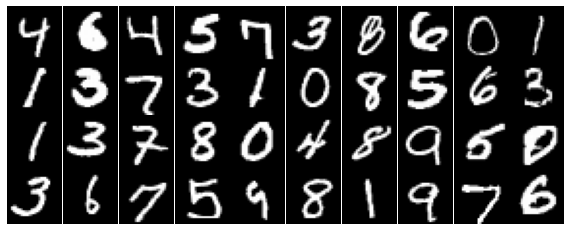

In [9]:



################### hyper parameter ##############################


lr=5e-5
img_dim = 28  
channel = 1
batch_size = 64
z_dim = 128



# ################### get dataset ##################################
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()
def preprocess(image,image2):
    if channel == 1:
        image = tf.expand_dims(image, -1)
        image2 = tf.expand_dims(image2, -1)

    image = tf.cast(image,tf.float32)
    image = (image-127.5)/127.5
    
    image2 = tf.cast(image2,tf.float32)
    image2 = (image2-127.5)/127.5
    return image, image2
ds = tf.data.Dataset.from_tensor_slices((x_train, tf.random.shuffle(x_train)))
ds = ds.map(preprocess).shuffle(10000).batch(batch_size, drop_remainder=True)


    
for sample_images1,sample_images2 in ds.take(1):
    break

################### plot function ##################################
%matplotlib inline
def plot_image(x, n_row=3, n_col=10):
    if x.shape[-1] == 1:
        x = x[:,:,:,0]
    x = ((x+1)*127.5).numpy().astype(np.uint8)
    plt.figure(figsize=(n_col, n_row))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(1,n_row+1):
        for j in range(1,n_col+1):
            index = (i-1)*n_col + j
            plt.subplot(n_row,n_col,index)
            plt.imshow(x[index-1], cmap='gray')
            plt.axis("off")
    plt.show()
plot_image(sample_images1, n_row=4, n_col=10) 

In [10]:

num_layers = int(np.log2(img_dim)) - 3 #
max_num_channels = img_dim * 8
f_size = img_dim // 2**(num_layers + 1)

################# generator architecture #####################
def create_generator_model():
    z_in = tf.keras.layers.Input(shape=(z_dim, ))
    z = z_in

    z = tf.keras.layers.Dense(f_size**2 * max_num_channels)(z)
    z = tf.keras.layers.Reshape((f_size, f_size, max_num_channels))(z)
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.Activation('relu')(z)

    for i in range(num_layers):
        num_channels = max_num_channels // 2**(i + 1)
        z = tf.keras.layers.Conv2DTranspose(num_channels,
                            (5, 5),
                            strides=(2, 2),
                            padding='same')(z)
        z = tf.keras.layers.BatchNormalization()(z)
        z = tf.keras.layers.Activation('relu')(z)

    z = tf.keras.layers.Conv2DTranspose(channel, #
                        (5, 5),
                        strides=(2, 2),
                        padding='same')(z)
    z = tf.keras.layers.Activation('tanh')(z)

    generator = tf.keras.Model(z_in, z)
    return generator
################# discriminator architecture #####################
def create_discriminator_model():
    x_in = tf.keras.layers.Input(shape=(img_dim, img_dim, channel)) #
    x = x_in
    for i in range(num_layers + 1):
        num_channels = max_num_channels // 2**(num_layers - i)
        x = tf.keras.layers.Conv2D(num_channels,
                   (5, 5),
                   strides=(2, 2),
                   padding='same')(x)
        if i > 0:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Flatten()(x)
    x_embedding1 = tf.keras.layers.Dense(z_dim)(x)


    discriminator = tf.keras.Model(x_in, x_embedding1)
    return discriminator

In [11]:


generator_optimizer = tf.optimizers.RMSprop(lr,0.99)
discriminator_optimizer = tf.optimizers.RMSprop(lr,0.99)


loss_obj = tf.nn.sigmoid_cross_entropy_with_logits
def loss_ones_fn(logits):
  y = tf.ones_like(logits)
  loss = loss_obj(y,logits)
  return loss
def loss_zeros_fn(logits):
  y = tf.zeros_like(logits)
  loss = loss_obj(y,logits)
  return loss 


def gradient_penalty(real_data, generated_data):
    alpha = tf.random.uniform((batch_size,1,1,1),minval=0,maxval=1,dtype=tf.float32)

    interpolated = alpha * real_data + (1 - alpha) * generated_data
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        prob_interpolated = discriminator(interpolated)
        gradients = tape.gradient(prob_interpolated,interpolated)

    gradients = tf.reshape(gradients,(batch_size,-1))
    gradients_norm = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=1))
    # Return gradient penalty
    return 10*tf.reduce_mean((gradients_norm) ** 2)

@tf.function
def train(real_images, real_images2):
 
    #train discriminator
    for i in range(5):
        with tf.GradientTape() as discriminator_tape:
            z = tf.random.uniform((batch_size,z_dim), minval=-1.0, maxval=1.0)
            x = generator(z)  
            x_fake = discriminator(x)

            z2 = tf.random.uniform((batch_size,z_dim), minval=-1.0, maxval=1.0)
            x2 = generator(z2)  
            x_fake2 = discriminator(x2)

            x_real = discriminator(real_images)

            loss = tf.losses.MSE(tf.reduce_mean(tf.square(x_fake - x_fake2), -1),0.0) \
            + tf.losses.MSE(tf.reduce_mean(tf.square(x_real - discriminator(real_images2)), -1),1.0)
            rec_loss = tf.reduce_mean(tf.losses.MSE(x_fake, z))
            discriminator_loss = rec_loss + tf.reduce_mean(loss) + gradient_penalty(real_images, x)

    discriminator_grads = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables )
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables ))

    # train generator
    with tf.GradientTape() as generator_tape:
        z  = tf.random.uniform((batch_size,z_dim), minval=-1.0, maxval=1.0)
        x = generator(z)
        x_fake = discriminator(x)

        z2 = tf.random.uniform((batch_size,z_dim), minval=-1.0, maxval=1.0)
        x2 = generator(z2)  
        x_fake2 = discriminator(x2)
        
        loss = tf.losses.MSE(tf.reduce_mean(tf.square(x_fake - x_fake2), -1),1.0) 
        generator_loss = tf.reduce_mean(loss)
    generator_grads = generator_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss,discriminator_loss



generator = create_generator_model()
generator.summary()
discriminator = create_discriminator_model()
discriminator.summary()

train(sample_images1, tf.random.shuffle(sample_images1))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_5 (Dense)             (None, 10976)             1415904   
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 224)         0         
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 224)        896       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 7, 7, 224)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 112)      627312    
 ranspose)                                                 

(<tf.Tensor: shape=(), dtype=float32, numpy=0.999997>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.3546443>)

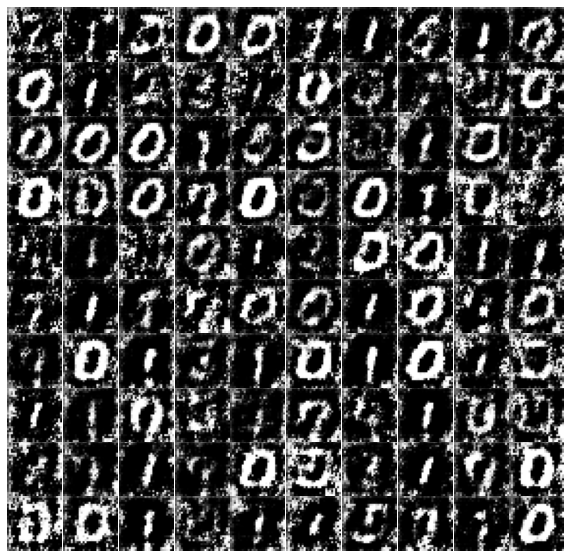

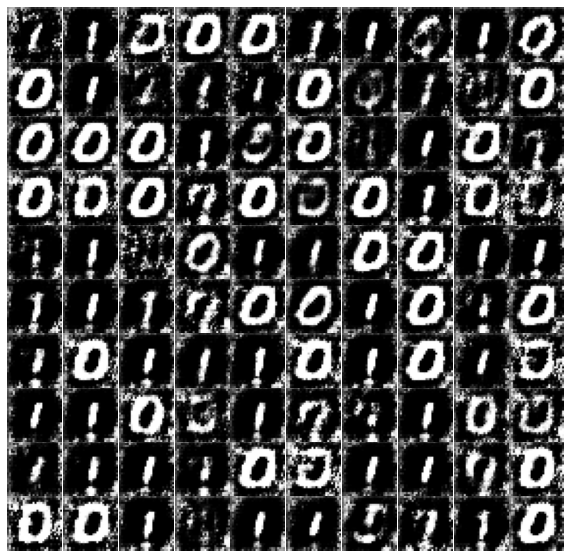

In [ ]:

epochs = 1000
for epoch in range(epochs):
    for i,(real_images1,real_images2) in enumerate(iter(ds)):
        generator_loss,discriminator_loss = train(real_images1, tf.random.shuffle(real_images1))

    if epoch % 50 == 0:
        n_row,n_col = 10,10 
        sample_z = tf.random.uniform((n_row*n_col,z_dim), minval=-1.0, maxval=1.0)
        sample_fake_image = generator(sample_z)
        plot_image(sample_fake_image, n_row=n_row, n_col=n_row)
        plot_image(generator(discriminator(sample_fake_image)), n_row=n_row, n_col=n_row)
